In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../../Code/')
from utils import read_dataset_log
import scanpy as sc
from scipy.stats import spearmanr
import os

In [50]:
from matplotlib import rcParams, font_manager
import matplotlib


rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [3]:
figdir = '../../Figures/Components/'

In [98]:
! wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_44/gencode.v44.chr_patch_hapl_scaff.basic.annotation.gtf.gz
! mv gencode.v44.chr_patch_hapl_scaff.basic.annotation.gtf.gz ../../Data/Misc
! gzip -d ../../Data/Misc/gencode.v44.chr_patch_hapl_scaff.basic.annotation.gtf.gz

--2023-12-17 22:26:35--  https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_44/gencode.v44.chr_patch_hapl_scaff.basic.annotation.gtf.gz
Resolving ftp.ebi.ac.uk... 193.62.193.165
Connecting to ftp.ebi.ac.uk|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32188006 (31M) [application/x-gzip]
Saving to: “gencode.v44.chr_patch_hapl_scaff.basic.annotation.gtf.gz”

100%[======================================>] 32,188,006   673K/s   in 48s     

2023-12-17 22:27:24 (660 KB/s) - “gencode.v44.chr_patch_hapl_scaff.basic.annotation.gtf.gz” saved [32188006/32188006]



In [116]:
gtf = pd.read_csv('../../Data/Misc/gencode.v44.chr_patch_hapl_scaff.basic.annotation.gtf', sep='\t', skiprows=5, header=None)
gtf = gtf.loc[gtf[2] == 'gene', :]
gtf.head()

,0,1,2,3,4,5,6,7,8
0,chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000290825.1""; gene_type ""lncRNA..."
5,chr1,HAVANA,gene,12010,13670,.,+,.,"gene_id ""ENSG00000223972.6""; gene_type ""transc..."
13,chr1,HAVANA,gene,14404,29570,.,-,.,"gene_id ""ENSG00000227232.5""; gene_type ""unproc..."
26,chr1,ENSEMBL,gene,17369,17436,.,-,.,"gene_id ""ENSG00000278267.1""; gene_type ""miRNA""..."
29,chr1,HAVANA,gene,29554,31109,.,+,.,"gene_id ""ENSG00000243485.5""; gene_type ""lncRNA..."


In [117]:
def extract_gene_info(s, feature='gene_type'):
    gene_type_match = re.search(r'%s "(.*?)";' % feature, s)
    gene_type = gene_type_match.group(1) if gene_type_match else None
    return gene_type

In [118]:
gtf['type'] = gtf[8].apply(lambda x: extract_gene_info(x, 'gene_type'))
gtf['name'] = gtf[8].apply(lambda x: extract_gene_info(x, 'gene_name'))

In [119]:
gtf['type'].value_counts()

protein_coding                        23217
lncRNA                                20245
processed_pseudogene                  10886
unprocessed_pseudogene                 3432
misc_RNA                               2423
snRNA                                  2094
miRNA                                  1945
transcribed_unprocessed_pseudogene     1172
TEC                                    1123
snoRNA                                 1020
transcribed_processed_pseudogene        582
rRNA_pseudogene                         516
IG_V_pseudogene                         300
IG_V_gene                               228
transcribed_unitary_pseudogene          160
TR_V_gene                               160
unitary_pseudogene                      107
TR_J_gene                                93
rRNA                                     71
IG_D_gene                                64
scaRNA                                   51
TR_V_pseudogene                          46
pseudogene                      

In [120]:
pcgenes = list(gtf.loc[gtf['type']=='protein_coding', 'name'])
lncgenes = list(gtf.loc[gtf['type']=='lncRNA', 'name'])
pseudogenes = list(gtf.loc[gtf['type'].isin(['processed_pseudogene', 'unprocessed_pseudogene', 'transcribed_unprocessed_pseudogene', 'transcribed_processed_pseudogene', 'transcribed_unitary_pseudogene', 'unitary_pseudogene', 'pseudogene']), 'name'])

In [7]:
gepinfo = read_dataset_log('Dataset Paths')
gepinfo.index = gepinfo['dataset']
gepinfo = gepinfo.loc[gepinfo['dataset_type'] == 'discovery', :]

In [140]:
qualityres = []
for d in gepinfo.index:
    print(d)
    dat = sc.read(gepinfo.at[d, 'raw_counts_fn'])
    if d not in ['Pan-Cancer', 'Pan-Tissue']:
        if d == 'TBRU':
            dat.var['_index'] = dat.var.index
            prot_ind = dat.var['_index'].apply(lambda x: '_protein' in x)
        else:
            prot_ind = dat.var['feature_types']=='Antibody Capture'    
        
        nadtcount = np.array(dat[:,prot_ind].X.sum(axis=1))
        nadt = np.array((dat[:,prot_ind].X >0).sum(axis=1))
        dat = dat[:,~prot_ind]
        
    mitoind = [x for x in dat.var.index if 'MT-' in x]
    mitocount = np.array(dat[:,mitoind].X.sum(axis=1))
    nrnacount = np.array(dat.X.sum(axis=1))
    nrna = np.array((dat.X >0).sum(axis=1))
    asgene = [x for x in dat.var.index if ('-AS1' in x) or ('AS-2' in x)]
    dot = [x for x in dat.var.index if '.' in x]
    dotcount = np.array(dat[:,dot].X.sum(axis=1))
    ascount = np.array(dat[:,asgene].X.sum(axis=1))  


    pccount = np.array(dat[:,dat.var.index.isin(pcgenes)].X.sum(axis=1)).reshape(-1,1)
    lnccount = np.array(dat[:,dat.var.index.isin(lncgenes)].X.sum(axis=1)).reshape(-1,1)
    pseudocount = np.array(dat[:,dat.var.index.isin(pseudogenes)].X.sum(axis=1)).reshape(-1,1)
    othercount = np.array(dat[:,~dat.var.index.isin(pcgenes+lncgenes)].X.sum(axis=1)).reshape(-1,1)

    
    
    if d not in ['Pan-Cancer', 'Pan-Tissue']:   
        dres = pd.DataFrame(np.concatenate([nrnacount, nrna, mitocount, dotcount, ascount, nadtcount, nadt, pccount, lnccount, pseudocount, othercount], axis=1),
                            columns=['RNA_Count', 'RNA_Detected', 'Mitocount', 'Dot_Count', 'AS_Count', 'ADT_Count', 'ADT_Detected', 'PCgene_Count', 'LncGene_Count', 'PseudoGene_Count', 'OtherGene_Count'])
        dres['Max_ADT'] = (prot_ind==True).sum()
    else:
        dres = pd.DataFrame(np.concatenate([nrnacount, nrna, mitocount, dotcount, ascount, pccount, lnccount, pseudocount, othercount ], axis=1),
                            columns=['RNA_Count', 'RNA_Detected', 'Mitocount', 'Dot_Count', 'AS_Count', 'PCgene_Count', 'LncGene_Count', 'PseudoGene_Count', 'OtherGene_Count'])
    
    dres.index = dat.obs.index    
    dres['Max_RNA'] = dat.shape[1]
    dres['Dataset'] = d    
    qualityres.append(dres)
        
        
    

AMP-RA
Only considering the two last: ['.ADTfixed', '.h5ad'].
Only considering the two last: ['.ADTfixed', '.h5ad'].
Pan-Cancer
Only considering the two last: ['.NoPBMC', '.h5ad'].
Only considering the two last: ['.NoPBMC', '.h5ad'].
TBRU
HIV-Vaccine
Only considering the two last: ['.ADTfixed', '.h5ad'].
Only considering the two last: ['.ADTfixed', '.h5ad'].
UK-Covid
Only considering the two last: ['.ADTfixed', '.h5ad'].
Only considering the two last: ['.ADTfixed', '.h5ad'].
COMBAT
Only considering the two last: ['.ADTfixed', '.h5ad'].
Only considering the two last: ['.ADTfixed', '.h5ad'].
Pan-Tissue


In [202]:
qualityres['Dataset'].value_counts()

UK-Covid       612982
TBRU           500089
COMBAT         400925
Pan-Cancer     215048
Pan-Tissue     169628
AMP-RA          94048
HIV-Vaccine     73259
Name: Dataset, dtype: int64

In [141]:
qualityres= pd.concat(qualityres, axis=0)

In [142]:
qualityres.to_csv('../../Data/TCAT/QualityStats_AllDatasets.tsv', sep='\t')

In [4]:
qualityres = pd.read_csv('../../Data/TCAT/QualityStats_AllDatasets.tsv', sep='\t', index_col=0)
qualityres.head()

,RNA_Count,RNA_Detected,Mitocount,Dot_Count,AS_Count,ADT_Count,ADT_Detected,PCgene_Count,LncGene_Count,PseudoGene_Count,OtherGene_Count,Max_ADT,Max_RNA,Dataset
BRI-399_AAACGAATCTGCATGA,7560.0,2157.0,493.0,53.0,12.0,475.0,42.0,6992.0,396.0,0.0,174.0,58.0,33538,AMP-RA
BRI-399_AAACGCTTCCTTGACC,2563.0,1171.0,417.0,22.0,10.0,442.0,47.0,2231.0,260.0,0.0,73.0,58.0,33538,AMP-RA
BRI-399_AAAGGGCAGCCGGAAT,4922.0,1741.0,361.0,20.0,18.0,292.0,41.0,4477.0,341.0,0.0,105.0,58.0,33538,AMP-RA
BRI-399_AAAGGGCCACTATGTG,3968.0,1619.0,273.0,14.0,5.0,382.0,45.0,3586.0,279.0,0.0,106.0,58.0,33538,AMP-RA
BRI-399_AAAGGTAGTGCAGGAT,4101.0,1492.0,370.0,23.0,7.0,425.0,47.0,3735.0,265.0,0.0,102.0,58.0,33538,AMP-RA


In [8]:
tcat_usage = []
for d in gepinfo.index:
    dat = pd.read_csv(gepinfo.loc[d, 'tcat_fn'], sep='\t', index_col=0)
    tcat_usage.append(dat)
    
tcat_usage = pd.concat(tcat_usage, axis=0)

In [9]:
cgep_info = read_dataset_log(tabname='cGEP_Name')
cgep_info.head()

,cGep_Name,Old_Short_Name,Long_Name,Short_Name,Shortest_Name,Class,Num_Datasets,Notes,Reviewed,Filter
0,COMBAT_Cytoskeleton,Cytoskeleton,Actin Cytoskeleton,Cytoskeleton,Cytosk.,Functional,7.0,NaN,Y,NaN
1,CD8_EM,CD8-EM,CD8 Effector Memory,CD8-EM,CD8-EM,Lineage,7.0,Need to confirm overlap with gating since the ...,Y,NaN
2,CellCycle-G2M,CellCycle-G2M,Cell Cycle G2M Phase,CellCycle-G2M,G2M-phase,Functional,7.0,NaN,Y,NaN
3,CellCycle-S,CellCycle-S,Cell Cycle S Phase,CellCycle-S,S-phase,Functional,7.0,NaN,Y,NaN
4,Cytotoxic,Cytotoxic,Cytotoxic,Cytotoxic,Cytotoxic,Functional,7.0,NaN,Y,NaN


In [10]:
rename_map = dict(zip(cgep_info['cGep_Name'], cgep_info['Short_Name']))

In [11]:
tcat_usage = tcat_usage.rename(columns=rename_map)

In [12]:
tcat_usage_norm = tcat_usage.div(tcat_usage.sum(axis=1), axis=0)

In [13]:
qualityres['MitoFrac'] = qualityres['Mitocount'] / qualityres['RNA_Count']
qualityres['DotFrac'] = qualityres['Dot_Count'] / qualityres['RNA_Count']
qualityres['ASFrac'] = qualityres['AS_Count'] / qualityres['RNA_Count']
qualityres['PCFrac'] = qualityres['PCgene_Count'] / qualityres['RNA_Count']
qualityres['OtherFrac'] = qualityres['OtherGene_Count'] / qualityres['RNA_Count']


In [14]:
qualityres.head()

,RNA_Count,RNA_Detected,Mitocount,Dot_Count,AS_Count,ADT_Count,ADT_Detected,PCgene_Count,LncGene_Count,PseudoGene_Count,OtherGene_Count,Max_ADT,Max_RNA,Dataset,MitoFrac,DotFrac,ASFrac,PCFrac,OtherFrac
BRI-399_AAACGAATCTGCATGA,7560.0,2157.0,493.0,53.0,12.0,475.0,42.0,6992.0,396.0,0.0,174.0,58.0,33538,AMP-RA,0.065212,0.007011,0.001587,0.924868,0.023016
BRI-399_AAACGCTTCCTTGACC,2563.0,1171.0,417.0,22.0,10.0,442.0,47.0,2231.0,260.0,0.0,73.0,58.0,33538,AMP-RA,0.162700,0.008584,0.003902,0.870464,0.028482
BRI-399_AAAGGGCAGCCGGAAT,4922.0,1741.0,361.0,20.0,18.0,292.0,41.0,4477.0,341.0,0.0,105.0,58.0,33538,AMP-RA,0.073344,0.004063,0.003657,0.909590,0.021333
BRI-399_AAAGGGCCACTATGTG,3968.0,1619.0,273.0,14.0,5.0,382.0,45.0,3586.0,279.0,0.0,106.0,58.0,33538,AMP-RA,0.068800,0.003528,0.001260,0.903730,0.026714
BRI-399_AAAGGTAGTGCAGGAT,4101.0,1492.0,370.0,23.0,7.0,425.0,47.0,3735.0,265.0,0.0,102.0,58.0,33538,AMP-RA,0.090222,0.005608,0.001707,0.910753,0.024872


In [15]:
tcat_usage_norm = tcat_usage.div(tcat_usage.sum(axis=1), axis=0)

In [16]:
tcat_usage_norm.head()

,CellCycle-G2M,Translation,HLA,ISG,Mito,Doublet-RBC,gdT,CellCycle-S,Cytotoxic,Doublet-Platelet,...,Tfh-2,OX40/EBI3,CD172a/MERTK,IEG3,Doublet-Fibroblast,SOX4/TOX2,CD40LG/TXNIP,Tph,Exhaustion,Tfh-1
BRI-399_AAACGAATCTGCATGA,0.001038,2.612040e-02,0.003684,0.001900,0.002439,0.000695,0.002736,0.002186,0.008307,0.008808,...,0.003477,0.003261,0.072440,0.061290,0.063067,0.005426,0.092357,0.002629,0.003716,0.004308
BRI-399_AAACGCTTCCTTGACC,0.000607,2.677540e-07,0.005257,0.026867,0.020592,0.000489,0.021852,0.007564,0.017953,0.030330,...,0.002284,0.003821,0.000077,0.000027,0.258754,0.007630,0.002795,0.002731,0.011667,0.026190
BRI-399_AAAGGGCAGCCGGAAT,0.000208,2.512893e-04,0.004975,0.000205,0.000156,0.000632,0.005665,0.001940,0.000578,0.010467,...,0.020819,0.015690,0.003089,0.024834,0.215833,0.041257,0.057163,0.006290,0.009659,0.009506
BRI-399_AAAGGGCCACTATGTG,0.002002,1.572197e-05,0.024665,0.003690,0.000146,0.000547,0.030107,0.001764,0.022393,0.001231,...,0.001682,0.003821,0.000607,0.000089,0.098537,0.005345,0.003486,0.010658,0.032946,0.016355
BRI-399_AAAGGTAGTGCAGGAT,0.000378,2.439907e-04,0.003139,0.003949,0.001677,0.000507,0.009709,0.001582,0.010546,0.001003,...,0.000624,0.028187,0.000799,0.003900,0.094384,0.019081,0.000709,0.006932,0.002121,0.000174


In [18]:
res = {}


for feat in ['MitoFrac', 'RNA_Detected', 'RNA_Count', 'DotFrac', 'ASFrac', 'PCFrac', 'OtherFrac']:
    res[feat] = []
    dataset = []
    for (k,g) in qualityres.groupby('Dataset'):
        dataset.append(k)    
        overlap = list(set(g.index).intersection(tcat_usage_norm.index))
        res[feat].append(tcat_usage_norm.loc[overlap, :].corrwith(g.loc[overlap, feat]))
    
    
    res[feat] = pd.concat(res[feat], axis=1)
    res[feat].columns = dataset

In [21]:
for feat in ['MitoFrac', 'RNA_Detected', 'RNA_Count', 'DotFrac', 'ASFrac', 'PCFrac', 'OtherFrac']:
    print(feat)
    if feat in ['RNA_Detected', 'RNA_Count']:
        display(res[feat].median(axis=1).sort_values(ascending=True).head(5))
    else:
        display(res[feat].median(axis=1).sort_values(ascending=False).head(5))
    print('\n\n')

MitoFrac


Mito                   0.819336
Poor-Quality           0.266278
Doublet-Plasmablast    0.134801
Doublet-Myeloid        0.129638
CD8-Trm                0.110307
dtype: float64




RNA_Detected


Mito                  -0.174681
CD172a/MERTK          -0.111142
Doublet-Plasmablast   -0.111102
Doublet-Myeloid       -0.098358
IEG                   -0.094051
dtype: float64




RNA_Count


Poor-Quality          -0.177928
CD8-EM                -0.111474
Mito                  -0.100433
Doublet-Plasmablast   -0.080380
Doublet-Myeloid       -0.074103
dtype: float64




DotFrac


Poor-Quality           0.271629
IEG                    0.143331
Treg                   0.053585
CD40LG/TXNIP           0.049452
Doublet-Plasmablast    0.045590
dtype: float64




ASFrac


Poor-Quality           0.232328
Doublet-Plasmablast    0.082819
IL10/IL19              0.047640
BCL2/FAM13A            0.043922
Tfh-1                  0.041601
dtype: float64




PCFrac


Translation     0.253832
NME1/FABP5      0.248210
Cytoskeleton    0.229652
CD4-Naive       0.161343
ICOS/CD38       0.159921
dtype: float64




OtherFrac


Poor-Quality      0.352174
Exhaustion        0.120375
Treg              0.095406
Tph               0.084360
Multi-Cytokine    0.083541
dtype: float64

In [22]:
for feat in ['MitoFrac', 'RNA_Detected', 'RNA_Count', 'DotFrac', 'ASFrac', 'PCFrac', 'OtherFrac']:
    print(feat)
    if feat in ['RNA_Detected', 'RNA_Count']:
        display(res[feat].mean(axis=1).sort_values(ascending=True).head(5))
    else:
        display(res[feat].mean(axis=1).sort_values(ascending=False).head(5))
    print('\n\n')

MitoFrac


Mito                  0.811348
Poor-Quality          0.250045
Doublet-Myeloid       0.138040
gdT                   0.129878
Doublet-Fibroblast    0.125370
dtype: float64




RNA_Detected


Mito                 -0.221711
CD172a/MERTK         -0.186734
Doublet-Myeloid      -0.129447
Translation          -0.120925
Doublet-Fibroblast   -0.111338
dtype: float64




RNA_Count


Poor-Quality         -0.129785
CD8-EM               -0.117542
Mito                 -0.116202
Cytotoxic            -0.079976
Doublet-Fibroblast   -0.075225
dtype: float64




DotFrac


Poor-Quality           0.326305
IEG                    0.103902
Treg                   0.078618
Mito                   0.070392
Doublet-Plasmablast    0.060292
dtype: float64




ASFrac


Poor-Quality           0.214204
Doublet-Plasmablast    0.072092
Mito                   0.047012
IL10/IL19              0.046657
Treg                   0.040435
dtype: float64




PCFrac


NME1/FABP5      0.235205
Translation     0.221717
Cytoskeleton    0.188271
ICOS/CD38       0.154240
CD8-Naive       0.124297
dtype: float64




OtherFrac


Poor-Quality           0.274538
Exhaustion             0.125760
Tph                    0.117849
Doublet-Plasmablast    0.099068
CD8-EM                 0.093283
dtype: float64

In [23]:
res['PCFrac'].median(axis=1).sort_values(ascending=False)

Translation            0.253832
NME1/FABP5             0.248210
Cytoskeleton           0.229652
CD4-Naive              0.161343
ICOS/CD38              0.159921
Th2-Resting            0.145120
CD172a/MERTK           0.143767
CD8-Naive              0.137885
Th22                   0.122210
IEG3                   0.111580
Th17-Resting           0.106378
OX40/EBI3              0.104821
TIMD4/TIM3             0.089357
BCL2/FAM13A            0.082558
CD4-CM                 0.073884
CellCycle-S            0.068537
RGCC/MYADM             0.062455
Th2-Activated          0.055063
MAIT                   0.044811
CellCycle-G2M          0.040798
HLA                    0.040734
Metallothionein        0.040402
CD8-Trm                0.036940
IEG                    0.036465
CellCycle-Late-S       0.034908
Heatshock              0.028081
Th1-Like               0.025269
Th17-Activated         0.025055
Exhaustion             0.015016
IEG2                   0.011950
CTLA4/CD38             0.009681
Tfh-2   

In [24]:
res['OtherFrac'].median(axis=1).sort_values(ascending=False)

Poor-Quality           0.352174
Exhaustion             0.120375
Treg                   0.095406
Tph                    0.084360
Multi-Cytokine         0.083541
Doublet-Plasmablast    0.070170
HLA                    0.068911
CellCycle-Late-S       0.067966
CD8-EM                 0.067274
TEMRA                  0.053523
TIMD4/TIM3             0.050524
CellCycle-G2M          0.040231
Doublet-Bcell          0.038774
CellCycle-S            0.038433
IL10/IL19              0.038389
CTLA4/CD38             0.032500
OX40/EBI3              0.030078
CD8-Trm                0.024829
ISG                    0.023557
Mito                   0.021850
IEG2                   0.021062
SOX4/TOX2              0.018392
Doublet-Platelet       0.015843
Tfh-1                  0.012379
Heatshock              0.011819
Th17-Activated         0.011250
Doublet-Myeloid        0.010405
IEG                    0.010015
Tfh-2                  0.009196
gdT                    0.001989
RGCC/MYADM             0.001499
MAIT    

In [25]:
merged = pd.concat([tcat_usage_norm, qualityres], axis=1)


<AxesSubplot:xlabel='Dataset', ylabel='Mito'>

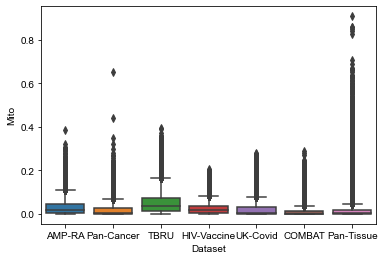

In [26]:
sns.boxplot(x='Dataset', y='Mito', data=merged)

<AxesSubplot:xlabel='Dataset', ylabel='Poor-Quality'>

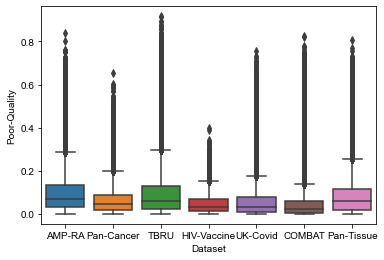

In [28]:
sns.boxplot(x='Dataset', y='Poor-Quality', data=merged)

<AxesSubplot:xlabel='Dataset', ylabel='Translation'>

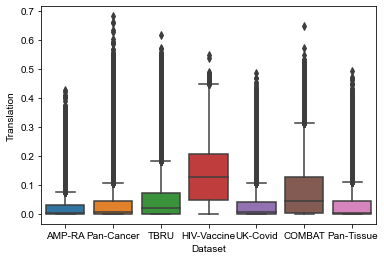

In [29]:
sns.boxplot(x='Dataset', y='Translation', data=merged)

Text(0.5, 1.0, 'GEP Usage correlation with # RNA Genes Detected')

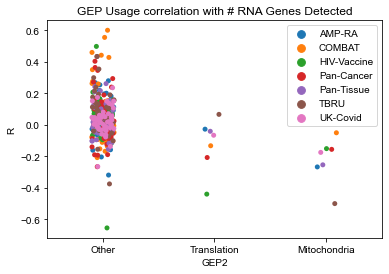

In [30]:
ucorr_unstack = res['RNA_Detected'].unstack().reset_index()
ucorr_unstack.columns = ['Dataset', 'GEP', 'R']
ucorr_unstack['GEP2'] = 'Other'
ind = ucorr_unstack['GEP'].isin(['Mito', 'MALAT1', 'Translation'])
ucorr_unstack.loc[ind, 'GEP2'] = ucorr_unstack.loc[ind, 'GEP'].replace({'Mito':'Mitochondria', 'PoorQuality_PoorQuality1':'MALAT1', 'Ribo_Translation':'Translation'})
ucorr_unstack['Dataset'] = ucorr_unstack['Dataset'].astype(str)

ax = sns.stripplot(x='GEP2', y='R', data=ucorr_unstack, hue='Dataset')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('GEP Usage correlation with # RNA Genes Detected')

[Text(0, 0, 'AMP-RA'),
 Text(1, 0, 'Pan-Cancer'),
 Text(2, 0, 'TBRU'),
 Text(3, 0, 'HIV-Vaccine'),
 Text(4, 0, 'UK-Covid'),
 Text(5, 0, 'COMBAT'),
 Text(6, 0, 'Pan-Tissue')]

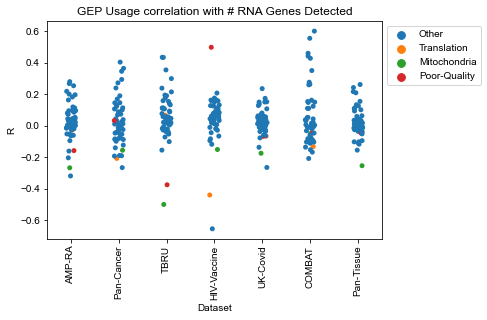

In [32]:
ucorr_unstack = res['RNA_Detected'].unstack().reset_index()
ucorr_unstack.columns = ['Dataset', 'GEP', 'R']
ucorr_unstack['GEP2'] = 'Other'
ind = ucorr_unstack['GEP'].isin(['Mito', 'Poor-Quality', 'Translation'])
ucorr_unstack.loc[ind, 'GEP2'] = ucorr_unstack.loc[ind, 'GEP'].replace({'Mito':'Mitochondria', 'PoorQuality_PoorQuality1':'MALAT1', 'Ribo_Translation':'Translation'})
ucorr_unstack['Dataset'] = ucorr_unstack['Dataset'].astype(str)

ax = sns.stripplot(x='Dataset', y='R', data=ucorr_unstack, hue='GEP2', order=gepinfo.index)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('GEP Usage correlation with # RNA Genes Detected')
ax.set_xticklabels(gepinfo.index, rotation=90)

In [33]:
from scipy.stats import ranksums

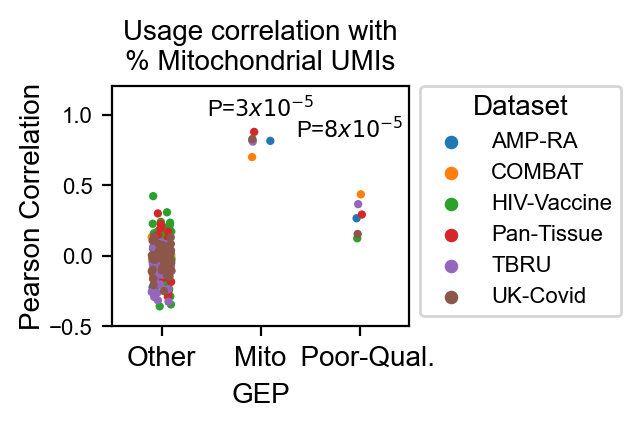

In [69]:
ucorr_unstack = res['MitoFrac'].unstack().reset_index()
ucorr_unstack.columns = ['Dataset', 'GEP', 'R']
ucorr_unstack['GEP2'] = 'Other'
ind = ucorr_unstack['GEP'].isin(['Mito', 'Poor-Quality'])
ucorr_unstack.loc[ind, 'GEP2'] = ucorr_unstack.loc[ind, 'GEP']
ucorr_unstack['Dataset'] = ucorr_unstack['Dataset'].astype(str)

## Mitochondrial genes were filtered out 
ucorr_unstack = ucorr_unstack.loc[ucorr_unstack['Dataset']!='Pan-Cancer', :]
ucorr_unstack['Dataset'] = ucorr_unstack['Dataset'].astype(str)


(fig,ax) = plt.subplots(1,1, figsize=(3.3,2), dpi=200, gridspec_kw={'right':0.65, 'left':0.2, 'top':0.8, 'bottom':.2})
ax = sns.stripplot(x='GEP2', y='R', data=ucorr_unstack, hue='Dataset', s=3)
ax.legend(bbox_to_anchor=(1,1.05), fontsize=8, markerscale=.5, title='Dataset')
ax.set_title('Usage correlation with\n% Mitochondrial UMIs', fontsize=10)
ax.set_ylabel('Pearson Correlation', labelpad=1, fontsize=10)
ax.set_xlabel('GEP', fontsize=10)
ax.set_xticklabels(['Other', 'Mito', '  Poor-Qual.'],  fontsize=10)
ax.set_ylim([-.5, 1.2])

ax.tick_params('y', labelsize=8)

x = ucorr_unstack.loc[ucorr_unstack['GEP2']=='Mito', 'R'].dropna()
y = ucorr_unstack.loc[(ucorr_unstack['GEP2']=='Other') & (ucorr_unstack['Dataset']!='Pan-Cancer'), 'R'].dropna()
Z,P=ranksums(x,y)


x = '%.0e'  % P
powstr = 'P=$%s x 10^{%s}$' % (x.split('e')[0], x.split('e')[1].replace('0', ''))
ax.text(1, 1.05, powstr, fontsize=8, ha='center', va='center')


x = ucorr_unstack.loc[ucorr_unstack['GEP2']=='Poor-Quality', 'R'].dropna()
y = ucorr_unstack.loc[(ucorr_unstack['GEP2']=='Other') & (ucorr_unstack['Dataset']!='Pan-Cancer'), 'R'].dropna()
Z,P=ranksums(x,y)

x = '%.0e'  % P
powstr = 'P=$%s x 10^{%s}$' % (x.split('e')[0], x.split('e')[1].replace('0', ''))
ax.text(1.9, .9, powstr, fontsize=8, ha='center', va='center')

plt.savefig(os.path.join(figdir, 'Corr_PctMito.png'))
plt.savefig(os.path.join(figdir, 'Corr_PctMito.pdf'))

In [70]:
x = ucorr_unstack.loc[ucorr_unstack['GEP']=='Mito', 'R'].dropna()
y = ucorr_unstack.loc[(ucorr_unstack['GEP']=='Other') & (ucorr_unstack['Dataset']!='Pan-Cancer'), 'R'].dropna()
y

Series([], Name: R, dtype: float64)

In [71]:
res['MitoFrac'].loc['Mito', :].mean()

0.8113479499252428

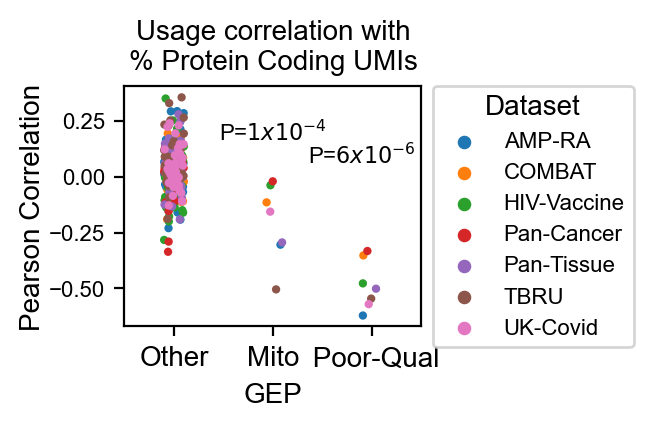

In [78]:
ucorr_unstack = res['PCFrac'].unstack().reset_index()
ucorr_unstack.columns = ['Dataset', 'GEP', 'R']
ucorr_unstack['GEP2'] = 'Other'
ind = ucorr_unstack['GEP'].isin(['Mito', 'Poor-Quality'])
ucorr_unstack.loc[ind, 'GEP2'] = ucorr_unstack.loc[ind, 'GEP'] #.replace({'Mito':'Mitochondria', 'PoorQuality_PoorQuality1':'MALAT1', 'Ribo_Translation':'Translation'})
ucorr_unstack['Dataset'] = ucorr_unstack['Dataset'].astype(str)


(fig,ax) = plt.subplots(1,1, figsize=(3.3,2), dpi=200, gridspec_kw={'right':0.65, 'left':0.2, 'top':0.8, 'bottom':.2})
ax = sns.stripplot(x='GEP2', y='R', data=ucorr_unstack, hue='Dataset', s=3)
ax.legend(bbox_to_anchor=(1,1.05), fontsize=8, markerscale=.5, title='Dataset')
ax.set_title('Usage correlation with\n% Protein Coding UMIs', fontsize=10)
ax.set_ylabel('Pearson Correlation', labelpad=1, fontsize=10)
ax.set_xlabel('GEP', fontsize=10)
ax.set_xticklabels(['Other', 'Mito', ' Poor-Qual'], fontsize=10)
#ax.set_ylim([-.5, 1.2])

ax.tick_params('y', labelsize=8)


x = ucorr_unstack.loc[ucorr_unstack['GEP2']=='Mito', 'R'].dropna()
y = ucorr_unstack.loc[(ucorr_unstack['GEP2']=='Other') & (ucorr_unstack['Dataset']!='Pan-Cancer'), 'R'].dropna()
Z,P=ranksums(x,y)

x = '%.0e'  % P
powstr = 'P=$%s x 10^{%s}$' % (x.split('e')[0], x.split('e')[1].replace('0', ''))

ax.text(1, 0.2, powstr, fontsize=8, ha='center', va='center')


x = ucorr_unstack.loc[ucorr_unstack['GEP2']=='Poor-Quality', 'R'].dropna()
y = ucorr_unstack.loc[(ucorr_unstack['GEP2']=='Other') & (ucorr_unstack['Dataset']!='Pan-Cancer'), 'R'].dropna()
Z,P=ranksums(x,y)

x = '%.0e'  % P
powstr = 'P=$%s x 10^{%s}$' % (x.split('e')[0], x.split('e')[1].replace('0', ''))
ax.text(1.9, .1, powstr, fontsize=8, ha='center', va='center')

plt.savefig(os.path.join(figdir, 'Corr_PctProtein.png'))
plt.savefig(os.path.join(figdir, 'Corr_PctProtein.pdf'))

## Output excel table

In [79]:
outfn = '../../Tables/Table_S4_CorrelationWithQualityMarkers.xlsx'

In [80]:
with pd.ExcelWriter(outfn) as writer:
    for k in ['MitoFrac', 'RNA_Detected', 'RNA_Count', 'PCFrac']:
        if k not in 'MitoFrac':
            order = res[k].mean(axis=1).sort_values(ascending=True).index
        else:
            order = res[k].mean(axis=1).sort_values(ascending=False).index
        res[k].index.name = 'GEP'
        res[k].loc[order,:].to_excel(writer, sheet_name=k)        

## Look within cell-type for example datasets

In [76]:
gepinfo.loc['COMBAT', 'metadata_fn']

'/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/COMBAT_PBMC/COMBAT-CITESeq-DATA.Raw.T.metadata.tsv'

In [77]:
combat_lineage = pd.read_csv(gepinfo.loc['COMBAT', 'manual_gating_fn'], sep='\t', index_col=0)['0']

In [78]:
combat_meta = pd.read_csv(gepinfo.loc['COMBAT', 'metadata_fn'], sep='\t', index_col=0)

In [79]:
tcat_usage_combat = tcat_usage.loc[combat_lineage.index, :]
tcat_usage_combat_norm = tcat_usage_combat.div(tcat_usage_combat.sum(axis=1), axis=0)

In [80]:
qualityres_combat = qualityres.loc[combat_lineage.index, :]

In [90]:
combat_res = []
for (k,g) in qualityres_combat.groupby(combat_meta['scRNASeq_sample_ID']):
    if g.shape[0] > 100:
        combat_res.append(tcat_usage_combat_norm.loc[g.index,:].corrwith(g['RNA_Detected']))

        
combat_res = pd.concat(combat_res, axis=1) 

In [108]:
hao_meta = pd.read_csv(gepinfo.loc['HIV-Vaccine', 'metadata_fn'], sep='\t', index_col=0)
qualityres_hao = qualityres.loc[hao_meta.index, :]
hao_lineage = pd.read_csv(gepinfo.loc['HIV-Vaccine', 'manual_gating_fn'], sep='\t', index_col=0)['0']

In [110]:
hao_res = []
for (k,g) in qualityres_hao.groupby(hao_meta['orig.ident']):
    if g.shape[0] > 100:
        hao_res.append(tcat_usage_norm.loc[g.index,:].corrwith(g['MitoFrac']))

        
hao_res = pd.concat(hao_res, axis=1) 
hao_res.mean(axis=1).sort_values(ascending=True)

CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Translation/T_Naive   -0.394657
?AB_CD278/ACTG1_CD4_CM-1_LIMS1/PASK                              -0.334923
?BCL2/CDK6_BCL2/CDK6                                             -0.308038
Doublet_Plasmablast                                              -0.274850
TBRU:ICOS/CCR4_Single                                            -0.266110
Ribo_Translation                                                 -0.258292
?SOX4/MME_SOX4/MME                                               -0.200796
HeatShock_HeatShock_NME1/FABP5_NME1/FABP5                        -0.197235
Pan-Tissue:?CH25H/DDIT4/SOCS3_Single                             -0.191620
Tfh                                                              -0.175841
?AB_CD278/ACTG1_AB_CD278/ACTG1                                   -0.158547
Pan-Cancer:CTSH/FURIN_Single                                     -0.132563
CD8_Naive                                                        -0.122804
Treg                     

In [113]:
hao_res = []
ind = hao_lineage == 'CD4_Memory'
for (k,g) in qualityres_hao.loc[ind,:].groupby(hao_meta.loc[ind, 'orig.ident']):
    if g.shape[0] > 50:
        hao_res.append(tcat_usage_norm.loc[g.index,:].corrwith(g['MitoFrac']))

        
hao_res = pd.concat(hao_res, axis=1) 
hao_res.mean(axis=1).sort_values(ascending=True)

CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Translation/T_Naive   -0.375562
CD8_Naive                                                        -0.346607
?AB_CD278/ACTG1_CD4_CM-1_LIMS1/PASK                              -0.291667
?BCL2/CDK6_BCL2/CDK6                                             -0.270179
?SOX4/MME_SOX4/MME                                               -0.232725
Doublet_Plasmablast                                              -0.229222
HeatShock_HeatShock_NME1/FABP5_NME1/FABP5                        -0.221860
Pan-Tissue:?CH25H/DDIT4/SOCS3_Single                             -0.194483
Pan-Tissue:CD244+CD8_Single                                      -0.176788
Tfh                                                              -0.168139
Pan-Cancer:CTSH/FURIN_Single                                     -0.158703
Treg                                                             -0.152850
HIV-Vaccine:Doublet_Plasmablast_Single                           -0.140466
PoorQuality_PoorQuality1 

CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Translation/T_Naive   -0.394657
?AB_CD278/ACTG1_CD4_CM-1_LIMS1/PASK                              -0.334923
?BCL2/CDK6_BCL2/CDK6                                             -0.308038
Doublet_Plasmablast                                              -0.274850
TBRU:ICOS/CCR4_Single                                            -0.266110
Ribo_Translation                                                 -0.258292
?SOX4/MME_SOX4/MME                                               -0.200796
HeatShock_HeatShock_NME1/FABP5_NME1/FABP5                        -0.197235
Pan-Tissue:?CH25H/DDIT4/SOCS3_Single                             -0.191620
Tfh                                                              -0.175841
?AB_CD278/ACTG1_AB_CD278/ACTG1                                   -0.158547
Pan-Cancer:CTSH/FURIN_Single                                     -0.132563
CD8_Naive                                                        -0.122804
Treg                     

In [105]:
g

,RNA_Count,RNA_Detected,Mitocount,Dot_Count,AS_Count,ADT_Count,ADT_Detected,Max_ADT,Max_RNA,Dataset,MitoFrac,DotFrac,ASFrac
E2L1_AAACGAACAGAGCTAG,6699.0,2050.0,489.0,24.0,7.0,3002.0,204.0,228.0,20729,HIV-Vaccine,0.072996,0.003583,0.001045
E2L1_AAACGAAGTGAATAAC,7357.0,1982.0,325.0,37.0,22.0,2766.0,185.0,228.0,20729,HIV-Vaccine,0.044176,0.005029,0.002990
E2L1_AAACGAATCTCCCATG,7461.0,1995.0,205.0,29.0,13.0,4240.0,214.0,228.0,20729,HIV-Vaccine,0.027476,0.003887,0.001742
E2L1_AAACGCTTCTCGACGG,7419.0,2408.0,259.0,23.0,14.0,4525.0,200.0,228.0,20729,HIV-Vaccine,0.034910,0.003100,0.001887
E2L1_AAATGGACATCGATGT,7153.0,1946.0,303.0,34.0,18.0,3297.0,198.0,228.0,20729,HIV-Vaccine,0.042360,0.004753,0.002516
...,...,...,...,...,...,...,...,...,...,...,...,...,...
E2L8_TTTATGCTCTCGTCGT,6562.0,2010.0,280.0,30.0,6.0,3593.0,196.0,228.0,20729,HIV-Vaccine,0.042670,0.004572,0.000914
E2L8_TTTCACAGTTAGAGTA,6199.0,1977.0,516.0,28.0,3.0,2981.0,197.0,228.0,20729,HIV-Vaccine,0.083239,0.004517,0.000484
E2L8_TTTCAGTGTGCGGTAA,7408.0,2137.0,307.0,40.0,17.0,2973.0,195.0,228.0,20729,HIV-Vaccine,0.041442,0.005400,0.002295
E2L8_TTTGGAGAGCCATGCC,6943.0,1918.0,315.0,43.0,17.0,3040.0,193.0,228.0,20729,HIV-Vaccine,0.045369,0.006193,0.002449


In [92]:
combat_res.mean(axis=1).sort_values()

Doublet_Plasmablast                                              -0.217274
CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Translation/T_Naive   -0.187125
?Doublet_Myeloid_?GutMyeloid2_MMP8_Doublet_Myeloid               -0.172354
Ribo_Translation                                                 -0.118969
Pan-Tissue:?CH25H/DDIT4/SOCS3_Single                             -0.115951
?BCL2/CDK6_BCL2/CDK6                                             -0.114548
Mito                                                             -0.105896
IEG_IEG2                                                         -0.099841
PoorQuality_PoorQuality1                                         -0.092549
TBRU:ICOS/CCR4_Single                                            -0.088697
CD8_Naive                                                        -0.088484
IEG_IEG1_KLF6/CXCR4                                              -0.075987
Effector_Memory_LYAR/GZMK                                        -0.071879
YPEL5/CREM               

In [71]:
tcat_usage_combat_norm

,CellCycle-G2M_CellCycle_G2M,ISG,gdT,Metallothionein,CellCycle-Sphase_CellCycle_S_DTL/FAM111B,Doublet_RBC,CellCycle-Histone_CellCycle-Histone2_CellCycle_Histone,HeatShock,Mito,?ANXA1/MYADM_?CCR10/LMNA_?IL32/S100A_CD4_Memory_LGALS1/S100A10,...,Pan-Cancer:CTSH/FURIN_Single,Pan-Cancer:Treg/TNFRSF18_Single,TBRU:ICOS/CCR4_Single,HIV-Vaccine:?KLRC2/GNLY_Single,HIV-Vaccine:?NK-Like_Single,HIV-Vaccine:Doublet_Plasmablast_Single,Pan-Tissue:?METRNL/CREM/LDLRAD4_Single,Pan-Tissue:CD244+CD8_Single,Pan-Tissue:?CH25H/DDIT4/SOCS3_Single,Pan-Tissue:NK-like_Single
AAACCTGAGCGGATCA-1-gPlexA1,1.143103e-04,0.000277,0.023031,4.744305e-03,4.555356e-04,0.000992,4.990224e-04,0.012085,4.747963e-07,8.245889e-02,...,1.545959e-02,0.025098,0.022942,0.059609,0.049706,0.004452,0.002574,0.010028,0.002439,0.002276
AAACCTGCAGCTCGAC-1-gPlexA1,1.448214e-04,0.009534,0.011474,1.181308e-03,2.965726e-03,0.000700,6.111064e-04,0.002627,8.144553e-05,5.354687e-02,...,4.269376e-03,0.040915,0.013391,0.002729,0.001604,0.022552,0.005292,0.009172,0.037329,0.001531
AAACCTGCATCTATGG-1-gPlexA1,6.680738e-05,0.002555,0.028944,1.386400e-04,9.420681e-04,0.000776,7.332334e-04,0.005086,4.428593e-04,6.625888e-03,...,9.947129e-03,0.009559,0.003513,0.040781,0.048441,0.010818,0.003600,0.029909,0.046574,0.004144
AAACCTGGTCTCTCTG-1-gPlexA1,3.782983e-04,0.021273,0.003730,1.096959e-02,3.715469e-03,0.000656,8.447108e-04,0.006801,4.237196e-05,1.250292e-02,...,9.783508e-02,0.058653,0.004341,0.002586,0.018602,0.001488,0.007619,0.010787,0.012285,0.002406
AAACCTGTCACCGGGT-1-gPlexA1,8.244215e-04,0.001854,0.041302,1.923482e-03,4.359864e-04,0.001098,4.124118e-04,0.001454,7.641217e-07,2.165331e-03,...,1.490541e-03,0.039085,0.003241,0.002861,0.018367,0.000892,0.000830,0.008899,0.002367,0.000632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCCTCAACC-1-gPlexK7,8.409378e-05,0.008899,0.004520,2.385125e-04,4.449311e-04,0.004024,5.136285e-04,0.000251,5.040878e-02,6.214589e-03,...,1.284919e-02,0.004702,0.016552,0.002508,0.001061,0.007120,0.012424,0.004253,0.008881,0.000540
TTTGGTTTCTCGATGA-1-gPlexK7,4.110245e-05,0.048172,0.001144,1.930855e-03,3.942873e-03,0.000469,1.330935e-04,0.000250,6.972259e-03,3.821545e-03,...,3.584589e-03,0.002138,0.014003,0.000851,0.002456,0.001186,0.000915,0.001404,0.009098,0.056200
TTTGTCACACCACGTG-1-gPlexK7,1.610481e-05,0.001090,0.093718,2.702138e-05,2.145580e-05,0.000353,8.070779e-06,0.000215,1.518592e-05,2.658686e-04,...,1.225475e-03,0.000294,0.000149,0.013905,0.129431,0.000911,0.001029,0.001736,0.002598,0.164053
TTTGTCAGTTACCGAT-1-gPlexK7,6.356932e-05,0.005806,0.026340,4.580338e-03,1.066156e-03,0.000696,1.420885e-04,0.008777,2.096773e-03,4.499255e-03,...,3.373967e-03,0.001851,0.007681,0.005865,0.006401,0.001081,0.002220,0.005955,0.004592,0.000288


In [61]:
tcat_usage_combat.sum(axis=1)

AAACCTGAGCGGATCA-1-gPlexA1    0.005824
AAACCTGCAGCTCGAC-1-gPlexA1    0.006320
AAACCTGCATCTATGG-1-gPlexA1    0.005523
AAACCTGGTCTCTCTG-1-gPlexA1    0.003442
AAACCTGTCACCGGGT-1-gPlexA1    0.011590
                                ...   
TTTGGTTTCCTCAACC-1-gPlexK7    0.004540
TTTGGTTTCTCGATGA-1-gPlexK7    0.010210
TTTGTCACACCACGTG-1-gPlexK7    0.013080
TTTGTCAGTTACCGAT-1-gPlexK7    0.005556
TTTGTCATCCTCTAGC-1-gPlexK7    0.001937
Length: 400925, dtype: float64

In [263]:

from datashader.mpl_ext import dsshow
import datashader as ds

import matplotlib.colors
cmap = plt.cm.hsv
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist = cmaplist[0:round(len(cmaplist)*0.7)]
cmaplist.reverse()
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', cmaplist, cmap.N)

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/datashader/mpl_ext.py:143: UserWarning: EqHistColorMapper warning: Histogram equalization did not converge.
  warnings.warn(
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/datashader/mpl_ext.py:143: UserWarning: EqHistColorMapper warning: Histogram equalization did not converge.
  warnings.warn(
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/datashader/mpl_ext.py:143: UserWarning: EqHistColorMapper warning: Histogram equalization did not converge.
  warnings.warn(


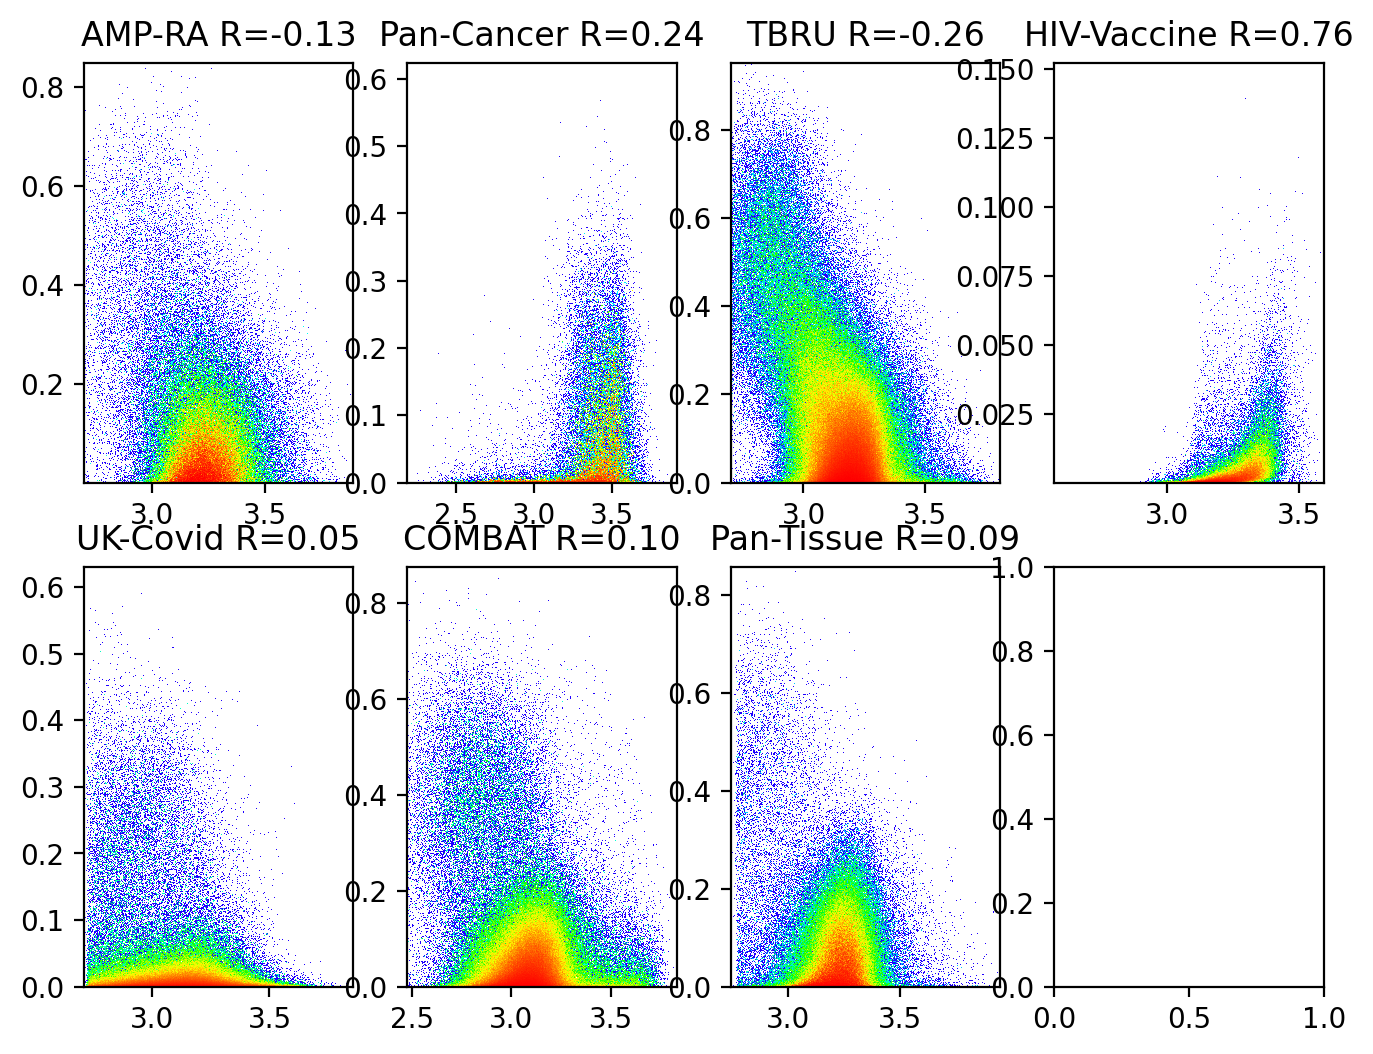

In [268]:
gep = 'PoorQuality_PoorQuality1'
(fig,axes) = plt.subplots(2, 4,figsize=(8,6), dpi=200)
axes = axes.ravel()
for i, dataset in enumerate(gepinfo.index):
    qdat = qualityres.loc[qualityres['Dataset']==dataset, :]
    tdat = tcat_usage.loc[qdat.index, :]
    #axes[i].scatter(qdat['RNA_Detected'].apply(np.log10), tdat[gep], s=1, edgecolor=None)
    dsshow(pd.DataFrame({'x':qdat['RNA_Detected'].apply(np.log10), 'y':tdat[gep]}), 
           ds.Point('x', 'y'), norm='eq_hist', cmap=cmap, ax = axes[i], aspect = 'auto')
    R,P = spearmanr(qdat['RNA_Detected'].apply(np.log10), tdat[gep])
    axes[i].set_title(dataset+' R=%.2f'%R)

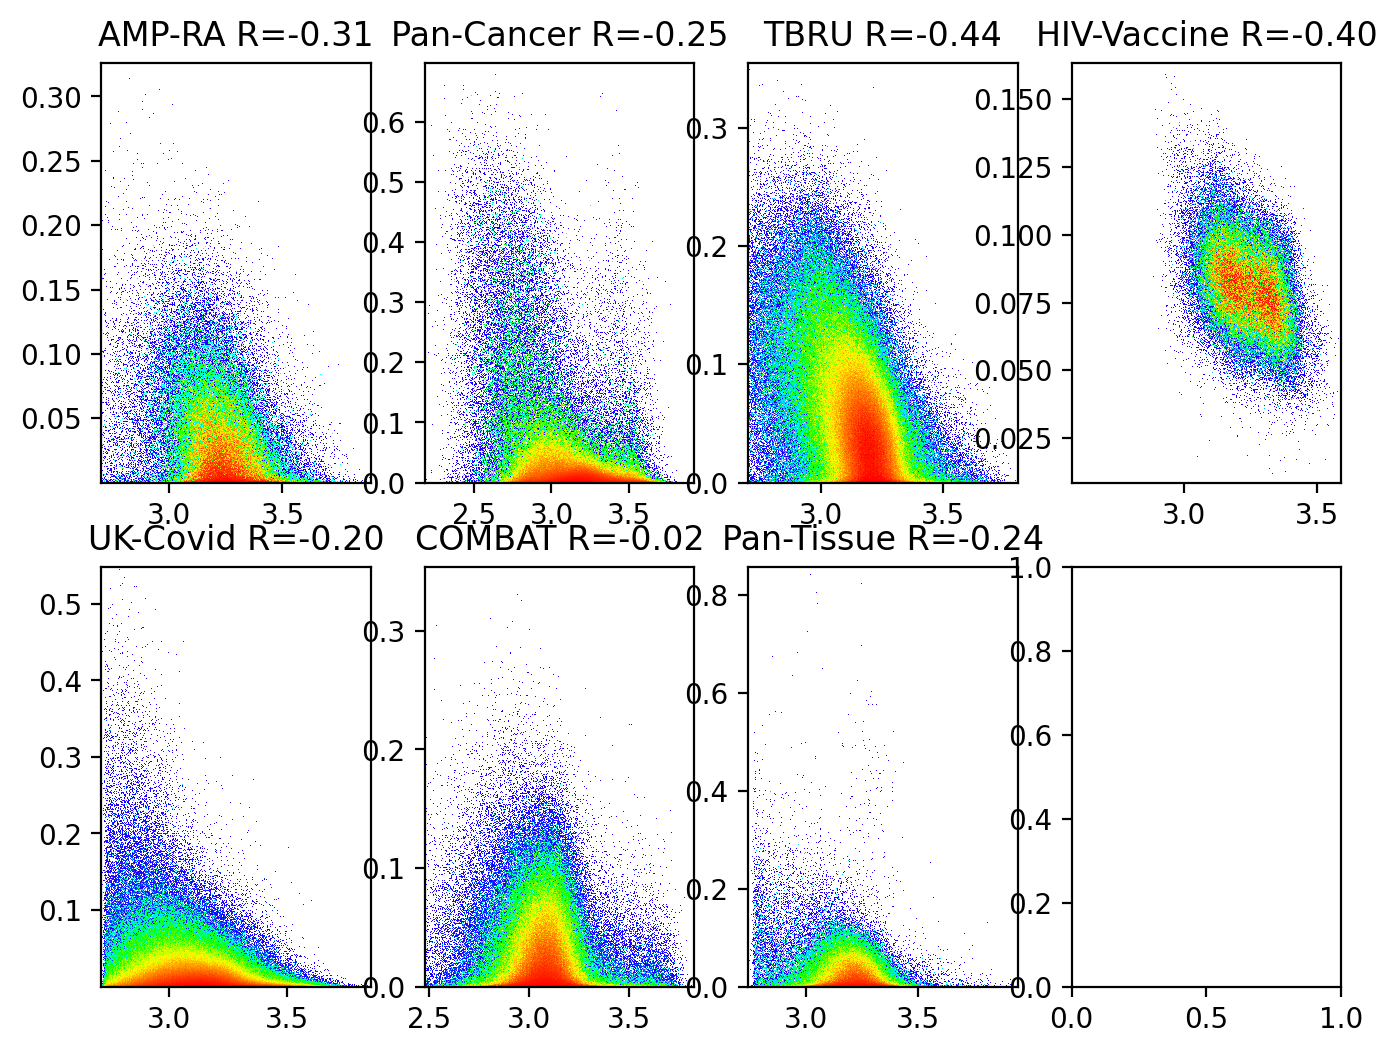

In [269]:
gep = 'Mito'
(fig,axes) = plt.subplots(2, 4,figsize=(8,6), dpi=200)
axes = axes.ravel()
for i, dataset in enumerate(gepinfo.index):
    qdat = qualityres.loc[qualityres['Dataset']==dataset, :]
    tdat = tcat_usage.loc[qdat.index, :]
    #axes[i].scatter(qdat['RNA_Detected'].apply(np.log10), tdat[gep], s=1, edgecolor=None)
    dsshow(pd.DataFrame({'x':qdat['RNA_Detected'].apply(np.log10), 'y':tdat[gep]}), 
           ds.Point('x', 'y'), norm='eq_hist', cmap=cmap, ax = axes[i], aspect = 'auto')
    R,P = spearmanr(qdat['RNA_Detected'].apply(np.log10), tdat[gep])
    axes[i].set_title(dataset+' R=%.2f'%R)

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/datashader/mpl_ext.py:143: UserWarning: EqHistColorMapper warning: Histogram equalization did not converge.
  warnings.warn(
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/datashader/mpl_ext.py:143: UserWarning: EqHistColorMapper warning: Histogram equalization did not converge.
  warnings.warn(
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/datashader/mpl_ext.py:143: UserWarning: EqHistColorMapper warning: Histogram equalization did not converge.
  warnings.warn(


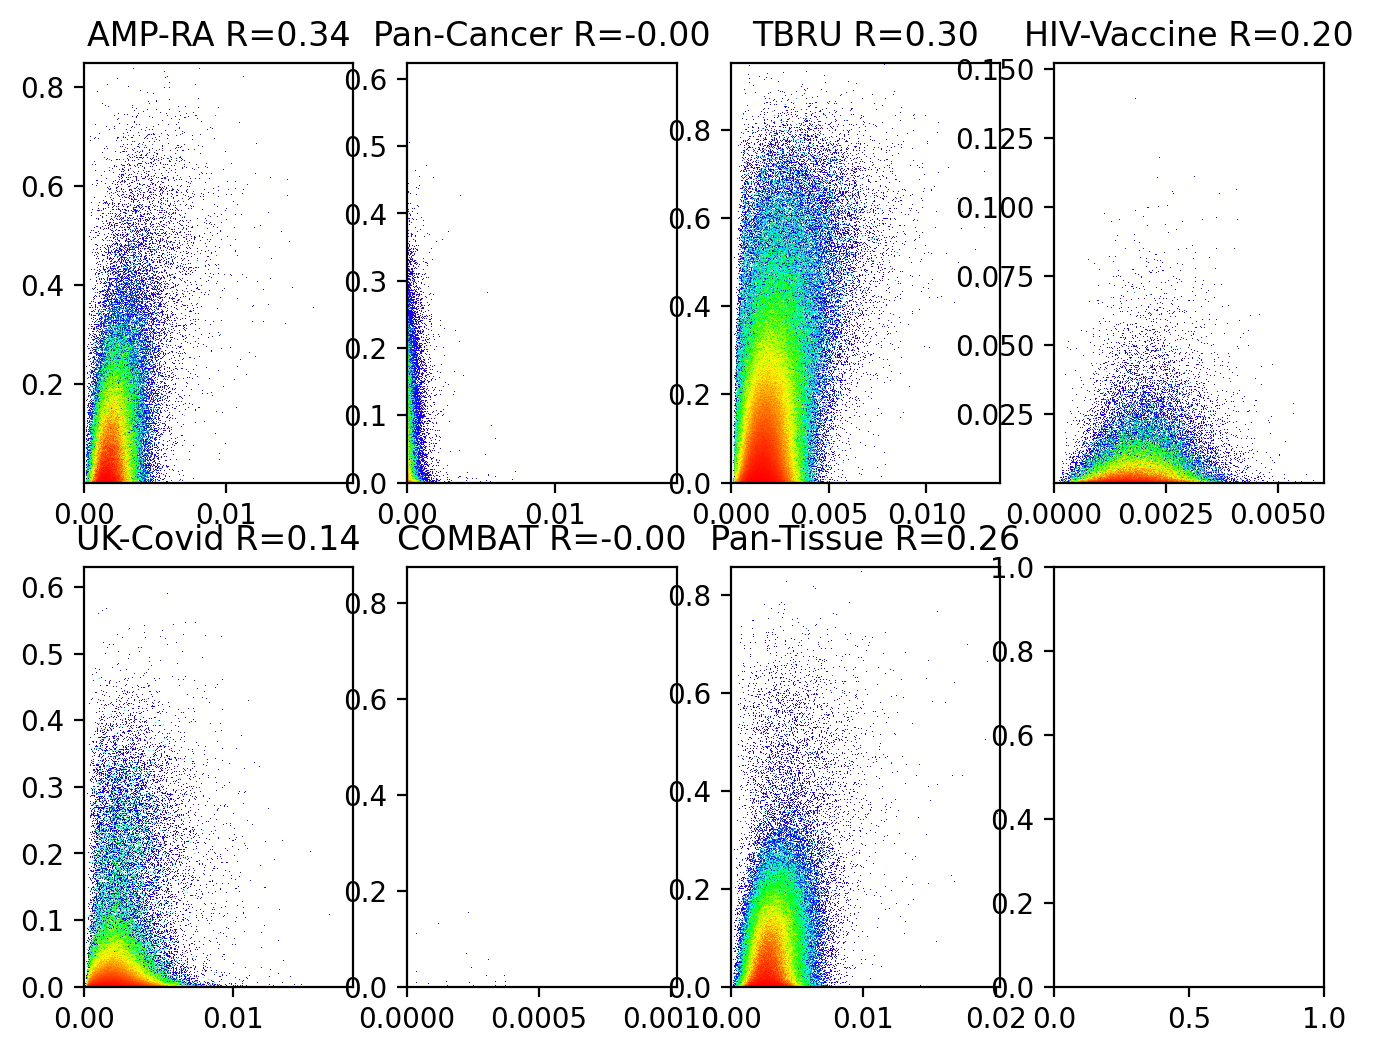

In [271]:
gep = 'PoorQuality_PoorQuality1'
(fig,axes) = plt.subplots(2, 4,figsize=(8,6), dpi=200)
axes = axes.ravel()
for i, dataset in enumerate(gepinfo.index):
    qdat = qualityres.loc[qualityres['Dataset']==dataset, :]
    tdat = tcat_usage.loc[qdat.index, :]
    #axes[i].scatter(qdat['RNA_Detected'].apply(np.log10), tdat[gep], s=1, edgecolor=None)
    dsshow(pd.DataFrame({'x':qdat['ASFrac'], 'y':tdat[gep]}), 
           ds.Point('x', 'y'), norm='eq_hist', cmap=cmap, ax = axes[i], aspect = 'auto')
    R,P = spearmanr(qdat['ASFrac'], tdat[gep])
    axes[i].set_title(dataset+' R=%.2f'%R)

In [291]:
d = 'HIV-Vaccine'
usage = pd.read_csv(gepinfo.at[d, 'usage_fn'], sep='\t', index_col=0)
usage = usage.div(usage.sum(axis=1), axis=0)
usage.corrwith(qualityres.loc[usage.index, 'RNA_Detected']).sort_values()

?TXNIP/H3F3B          -0.663675
Translation           -0.429509
Mito                  -0.328577
CD4_Naive             -0.179645
HLA                   -0.108795
Treg                  -0.102481
CD4_CM-1              -0.060291
IEG2                  -0.034606
?ANXA1/MYADM          -0.027865
Doublet_RBC           -0.023052
MAIT                  -0.011988
Cytoskeleton          -0.004940
?BCL2/CDK6             0.005679
CD8_Naive              0.017971
Doublet_Myeloid        0.023743
?SOX4/MME              0.036065
dnT/IL10+CD38+         0.045469
gdT                    0.065083
CellCycle_G2M          0.071020
Effector_Memory        0.076942
ISG                    0.077928
Doublet_Plasmablast    0.079931
Th2                    0.079972
Doublet_Platelet       0.089236
?MTRNR2L12             0.090542
IEG                    0.092717
CD8_CD160high          0.093333
?KLRC2/GNLY            0.114706
CellCycle_S            0.119552
CellCycle_Histone      0.124215
Cytotoxic              0.126380
Th17    

In [288]:
gepinfo

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,manual_gating_fn,metadata_fn,Processing notebook path,cNMF notebook path,cluster_col,name,cnmf_dir,k,dt,processed_forcnmf_fn,raw_counts_fn
dataset,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/mcurtis/GSK/tcell_proliferation/A...,/data/srlab1/mcurtis/GSK/tcell_proliferation/A...,/data/srlab1/mcurtis/GSK/tcell_proliferation/A...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...,NaN,/data/srlab1/mcurtis/GSK/tcell_proliferation/A...,/data/srlab1/mcurtis/GSK/tcell_proliferation/n...,/data/srlab1/mcurtis/GSK/tcell_proliferation/n...,cluster_name,amp_HarmonyRNA,/data/srlab1/mcurtis/GSK/tcell_proliferation/A...,35.0,0_2,/data/srlab1/mcurtis/GSK/tcell_proliferation/A...,/data/srlab1/mcurtis/GSK/tcell_proliferation/A...
Pan-Cancer,Pan-Cancer,/data/srlab1/mcurtis/GSK/tcell_proliferation/z...,/data/srlab1/mcurtis/GSK/tcell_proliferation/z...,/data/srlab1/mcurtis/GSK/tcell_proliferation/z...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...,NaN,/data/srlab1/mcurtis/GSK/tcell_proliferation/z...,/data/srlab1/mcurtis/GSK/tcell_proliferation/n...,/data/srlab1/mcurtis/GSK/tcell_proliferation/n...,meta.cluster,PanCancer_HarmonyRNA.20kgenes10X,/data/srlab1/mcurtis/GSK/tcell_proliferation/z...,38.0,0_15,/data/srlab1/mcurtis/GSK/tcell_proliferation/z...,/data/srlab1/mcurtis/GSK/tcell_proliferation/z...
TBRU,TBRU,/data/srlab1/mcurtis/GSK/tcell_proliferation/T...,/data/srlab1/mcurtis/GSK/tcell_proliferation/T...,/data/srlab1/mcurtis/GSK/tcell_proliferation/T...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...,NaN,/data/srlab1/mcurtis/GSK/tcell_proliferation/T...,/data/srlab1/mcurtis/GSK/tcell_proliferation/n...,/data/srlab1/mcurtis/GSK/tcell_proliferation/n...,cluster_name,TBRU_HarmonyRNA,/data/srlab1/mcurtis/GSK/tcell_proliferation/T...,35.0,0_2,/data/srlab1/mcurtis/GSK/tcell_proliferation/T...,/data/srlab1/mcurtis/GSK/tcell_proliferation/T...
HIV-Vaccine,HIV-Vaccine,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Analy...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Analy...,celltype.l2,T_learnHarmonyRNA_RefitBoth_20221022,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,35.0,0_2,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...
UK-Covid,UK-Covid,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...,NaN,/data/srlab1/dk718/COVID_PBMC/Data/Haniffa/han...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Analy...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Analy...,full_clustering,Haniffa_T_Script_learnHarmonyRNA_RefitBoth,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,40.0,0_2,/data/srlab1/dk718/COVID_PBMC/Data/Haniffa/han...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...
COMBAT,COMBAT,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/Manua...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Analy...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Analy...,Annotation_minor_subset,T_Script_learnHarmonyRNA_RefitBoth,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,44.0,0_2,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...
Pan-Tissue,Pan-Tissue,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...,NaN,/data/srlab1/dk

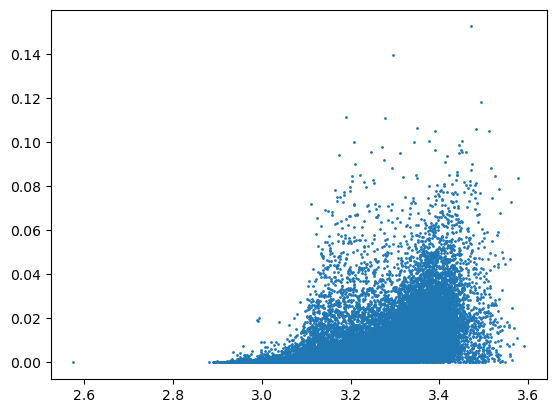

In [257]:
gep = 'PoorQuality_PoorQuality1'
dataset = 'HIV-Vaccine'
qdat = qualityres.loc[qualityres['Dataset']==dataset, :]
tdat = tcat_usage.loc[qdat.index, :]
plt.scatter(qdat['RNA_Detected'].apply(np.log10), tdat[gep], s=1, edgecolor=None)

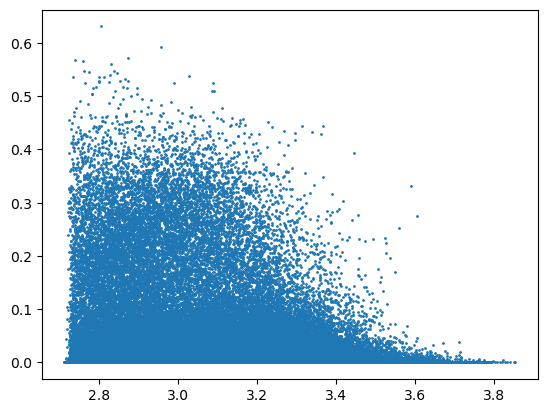

In [242]:
gep = 'PoorQuality_PoorQuality1'
dataset = 'UK-Covid'
qdat = qualityres.loc[qualityres['Dataset']==dataset, :]
tdat = tcat_usage.loc[qdat.index, :]
plt.scatter(qdat['RNA_Detected'].apply(np.log10), tdat[gep], s=1, edgecolor=None)

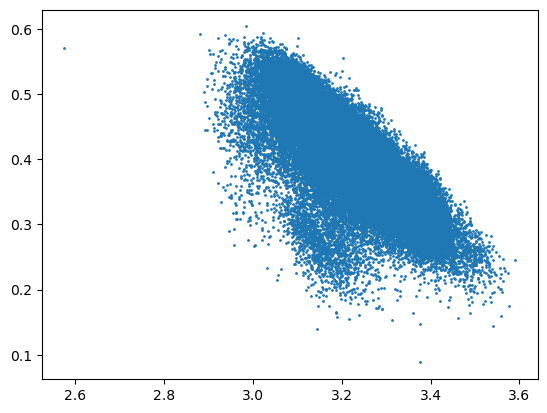

In [239]:
gep = 'Ribo_Translation'
dataset = 'HIV-Vaccine'
qdat = qualityres.loc[qualityres['Dataset']==dataset, :]
tdat = tcat_usage.loc[qdat.index, :]
plt.scatter(qdat['RNA_Detected'].apply(np.log10), tdat[gep], s=1, edgecolor=None)

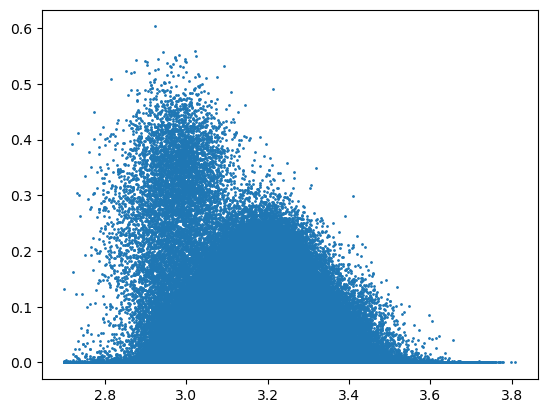

In [240]:
gep = 'Ribo_Translation'
dataset = 'TBRU'
qdat = qualityres.loc[qualityres['Dataset']==dataset, :]
tdat = tcat_usage.loc[qdat.index, :]
plt.scatter(qdat['RNA_Detected'].apply(np.log10), tdat[gep], s=1, edgecolor=None)

In [146]:
qdat

,RNA_Count,RNA_Detected,Dot_Count,AS_Count,ADT_Count,ADT_Detected,Max_ADT,Max_RNA,Dataset
L1_AAACCCAAGACATACA,5693.0,1615.0,21.0,11.0,5949.0,211.0,228.0,20729,HIV-Vaccine
L1_AAACCCACAACTGGTT,5066.0,1379.0,18.0,11.0,6547.0,217.0,228.0,20729,HIV-Vaccine
L1_AAACCCACAGCATACT,5854.0,1620.0,19.0,17.0,6318.0,219.0,228.0,20729,HIV-Vaccine
L1_AAACCCACATCAGTCA,4938.0,1632.0,19.0,4.0,5195.0,213.0,228.0,20729,HIV-Vaccine
L1_AAACCCATCCACACCT,4724.0,1217.0,18.0,9.0,4501.0,210.0,228.0,20729,HIV-Vaccine
...,...,...,...,...,...,...,...,...,...
E2L8_TTTGGTTTCGTCAACA,8178.0,2319.0,30.0,10.0,4557.0,205.0,228.0,20729,HIV-Vaccine
E2L8_TTTGTTGAGGCATGCA,7161.0,2046.0,27.0,9.0,3638.0,204.0,228.0,20729,HIV-Vaccine
E2L8_TTTGTTGAGTAGAGTT,7472.0,2240.0,43.0,20.0,4142.0,197.0,228.0,20729,HIV-Vaccine
E2L8_TTTGTTGCAGCGTGAA,7121.0,2131.0,38.0,10.0,3418.0,207.0,228.0,20729,HIV-Vaccine


In [138]:
ucorr.sort_values(by='Pan-Tissue')

,AMP-RA,COMBAT,HIV-Vaccine,Pan-Cancer,Pan-Tissue,TBRU,UK-Covid
Mito,-0.294650,-0.066136,-0.424636,-0.262866,-0.241987,-0.444078,-0.203635
Doublet_Plasmablast,-0.152156,-0.166362,0.332022,-0.052379,-0.154278,0.017928,0.056795
Effector_Memory_LYAR/GZMK,-0.077878,-0.068602,0.117159,-0.016035,-0.100955,-0.017336,-0.067682
PoorQuality_PoorQuality1,-0.199597,-0.093374,0.516715,0.377014,-0.093936,-0.404010,-0.083046
?Doublet_Myeloid_?GutMyeloid2_MMP8_Doublet_Myeloid,-0.210783,-0.140198,0.038706,-0.019094,-0.091328,-0.003722,0.081121
Pan-Tissue:?CH25H/DDIT4/SOCS3_Single,-0.013549,-0.114420,0.180923,-0.014030,-0.082397,-0.088400,-0.098464
Ribo_Translation,-0.038565,-0.121857,-0.764075,-0.413713,-0.073587,0.055111,-0.260596
CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Translation/T_Naive,-0.022349,-0.169071,-0.093035,-0.198122,-0.073002,0.121676,-0.130764
Doublet_Bcell_Doublet_Plasmablast,-0.074027,-0.047918,0.178945,-0.005522,-0.053483,0.008252,-0.054575
TBRU:ICOS/CCR4_Single,-0.026474,-0.088840,-0.253069,-0.162294,-0.047682,0.089370,-0.077583


In [133]:
ucorr.loc[order, :]

,AMP-RA,COMBAT,HIV-Vaccine,Pan-Cancer,Pan-Tissue,TBRU,UK-Covid
Ribo_Translation,-0.038565,-0.121857,-0.764075,-0.413713,-0.073587,0.055111,-0.260596
Mito,-0.294650,-0.066136,-0.424636,-0.262866,-0.241987,-0.444078,-0.203635
PoorQuality_PoorQuality1,-0.199597,-0.093374,0.516715,0.377014,-0.093936,-0.404010,-0.083046
?PlasmaDoublet/FCN3/FCN2/OIT3_CRHBP/CLEC4G,-0.068557,-0.011450,-0.011617,-0.313792,-0.028066,0.012372,0.094213
TBRU:ICOS/CCR4_Single,-0.026474,-0.088840,-0.253069,-0.162294,-0.047682,0.089370,-0.077583
?Doublet_Myeloid_?GutMyeloid2_MMP8_Doublet_Myeloid,-0.210783,-0.140198,0.038706,-0.019094,-0.091328,-0.003722,0.081121
CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Translation/T_Naive,-0.022349,-0.169071,-0.093035,-0.198122,-0.073002,0.121676,-0.130764
Doublet_Plasmablast,-0.152156,-0.166362,0.332022,-0.052379,-0.154278,0.017928,0.056795
IEG2,-0.017581,-0.106464,-0.052069,-0.143467,-0.015252,-0.045500,0.025567
Doublet_RBC,0.003544,0.001973,-0.130115,-0.002625,-0.000226,-0.005258,0.009332


In [95]:
nrnacount

array([7560., 2563., 4922., ..., 6273., 6519., 6602.])

In [93]:
    mitoind = [x for x in dat.var.index if 'MT-' in x]
    mitocount = np.array(dat[:,mitoind].X.sum(axis=1)).reshape(-1)
    nrnacount = np.array(dat.X.sum(axis=1)).reshape(-1)
    nrna = np.array((dat.X >0).sum(axis=1)).reshape(-1)
    asgene = [x for x in dat.var.index if ('-AS1' in x) or ('AS-2' in x)]
    dot = [x for x in dat.var.index if '.' in x]
    dotcount = np.array(dat[:,dot].X.sum(axis=1))
    ascount = np.array(dat[:,asgene].X.sum(axis=1))  
        
    
    if d not in ['Pan-Cancer', 'Pan-Tissue']:   
        dres = pd.DataFrame(np.concatenate([nrnacount, nrna, dotcount, ascount, nadtcount, nadt, ], axis=1), columns=['RNA_Count', 'RNA_Detected', 'Dot_Count', 'AS_Count', 'ADT_Count', 'ADT_Detected', ])
        dres['Max_ADT'] = (prot_ind==True).sum()
    else:
        dres = pd.DataFrame(np.concatenate([nrnacount, nrna, dotcount, ascount ], axis=1), columns=['RNA_Count', 'RNA_Detected', 'Dot_Count', 'AS_Count'])
    
    dres['Max_RNA'] = dat.shape[1]
    dres['Dataset'] = d
    qualityres.append(dres)

AxisError: axis 1 is out of bounds for array of dimension 1

In [90]:
qualityres

[]

In [84]:
        mitoind = [x for x in dat.var.index if 'MT-' in x]
        mitocount = np.array(dat[:,mitoind].X.sum(axis=1)).reshape(-1)
        nrnacount = np.array(dat.X.sum(axis=1)).reshape(-1)
        nrna = np.array((dat.X >0).sum(axis=1)).reshape(-1)
        asgene = [x for x in dat.var.index if ('-AS1' in x) or ('AS-2' in x)]
        dot = [x for x in dat.var.index if '.' in x]
        dotcount = np.array(dat[:,dot].X.sum(axis=1))
        ascount = np.array(dat[:,asgene].X.sum(axis=1)) 

In [88]:
pd.DataFrame(np.concatenate([nrnacount, nrna, dotcount, ascount], axis=1), columns=[ 'RNA_Count', 'RNA_Detected', 'Dot_Count', 'AS_Count'])

AxisError: axis 1 is out of bounds for array of dimension 1

In [67]:
        dat.var.index = dat.var['_index']
        prot_ind = dat.var['_index'].apply(lambda x: 'prot' in x)
        nadtcount = np.array(dat[:,prot_ind].X.sum(axis=1))
        nadt = np.array((dat[:,prot_ind].X >0).sum(axis=1))
        mitoind = [x for x in dat.var.index if 'MT-' in x]
        mitocount = np.array(dat[:,mitoind].X.sum(axis=1))
        nrnacount = np.array(dat[:,~prot_ind].X.sum(axis=1))
        nrna = np.array((dat[:,~prot_ind].X >0).sum(axis=1))
        asgene = [x for x in dat.var.index if ('-AS1' in x) or ('AS-2' in x)]
        dot = [x for x in dat.var.index if '.' in x]
        dotcount = np.array(dat[:,dot].X.sum(axis=1))
        ascount = np.array(dat[:,asgene].X.sum(axis=1))
        
        

In [76]:
dres['Max_RNA'] = (prot_ind==False).sum()
dres['Max_ADT'] = (prot_ind==True).sum()

In [57]:
pd.Series([x for x in dat.var.index if '-' in x]).apply(lambda x: x.split('-')[1]).value_counts()

AS1        973
AS2         89
1           86
DT          64
2           57
          ... 
HNRNPH2      1
C8orf76      1
SLURP2       1
TMEFF1       1
Fc           1
Length: 269, dtype: int64

In [75]:
(prot_ind==False).sum()

33538

In [6]:
\

dataset,AMP-RA,Pan-Cancer,TBRU,HIV-Vaccine,UK-Covid,COMBAT,Pan-Tissue
dataset,AMP-RA,Pan-Cancer,TBRU,HIV-Vaccine,UK-Covid,COMBAT,Pan-Tissue
usage_fn,/data/srlab1/mcurtis/GSK/tcell_proliferation/A...,/data/srlab1/mcurtis/GSK/tcell_proliferation/z...,/data/srlab1/mcurtis/GSK/tcell_proliferation/T...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...
gene_scores_fn,/data/srlab1/mcurtis/GSK/tcell_proliferation/A...,/data/srlab1/mcurtis/GSK/tcell_proliferation/z...,/data/srlab1/mcurtis/GSK/tcell_proliferation/T...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...
gene_tpm_fn,/data/srlab1/mcurtis/GSK/tcell_proliferation/A...,/data/srlab1/mcurtis/GSK/tcell_proliferation/z...,/data/srlab1/mcurtis/GSK/tcell_proliferation/T...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...
tcat_fn,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...
manual_gating_fn,NaN,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,NaN,/data/srlab1/TCAT/Data/PerDataset/COMBAT/Manua...,NaN
metadata_fn,/data/srlab1/mcurtis/GSK/tcell_proliferation/A...,/data/srlab1/mcurtis/GSK/tcell_proliferation/z...,/data/srlab1/mcurtis/GSK/tcell_proliferation/T...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/dk718/COVID_PBMC/Data/Haniffa/han...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...
Processing notebook path,/data/srlab1/mcurtis/GSK/tcell_proliferation/n...,/data/srlab1/mcurtis/GSK/tcell_proliferation/n...,/data/srlab1/mcurtis/GSK/tcell_proliferation/n...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Analy...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Analy...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Analy...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Analy...
cNMF notebook path,/data/srlab1/mcurtis/GSK/tcell_proliferation/n...,/data/srlab1/mcurtis/GSK/tcell_proliferation/n...,/data/srlab1/mcurtis/GSK/tcell_proliferation/n...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Analy...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Analy...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Analy...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Analy...
cluster_col,cluster_name,meta.cluster,cluster_name,celltype.l2,full_clustering,Annotation_minor_subset,Manually_curated_celltype


In [10]:
pd.read_csv(gepinfo.loc[d, 'metadata_fn'], sep='\t', index_col=0, nrows=5)

,orig.ident,nCount_RNA,nFeature_RNA,cell,sample,cluster,cell_type,donor,fibro,Tfilter,...,nGene,percent_mito,Tfilter2,cluster_number,cluster_name,UMAP1,UMAP2,n_counts,pct_mito,leiden
BRI-399_AAACGAATCTGCATGA,0,8035.0,2199,BRI-399_AAACGAATCTGCATGA,BRI-399,T-6: CD4+ memory,T cell,BRI-399,1,0,...,2157,0.065212,1,T-6,CD4+ memory,-0.747453,-0.735534,7507.0,0.065220,7
BRI-399_AAACGCTTCCTTGACC,0,3005.0,1218,BRI-399_AAACGCTTCCTTGACC,BRI-399,T-5: CD4+ GZMK+ memory,T cell,BRI-399,1,0,...,1171,0.162700,1,T-5,CD4+ GZMK+ memory,2.660266,0.749737,2540.0,0.162763,10
BRI-399_AAAGGGCAGCCGGAAT,0,5214.0,1782,BRI-399_AAAGGGCAGCCGGAAT,BRI-399,T-8: CD4+ CD25-high Treg,T cell,BRI-399,1,0,...,1741,0.073344,1,T-8,CD4+ CD25-high Treg,-2.114318,2.044475,4902.0,0.073344,16
BRI-399_AAAGGGCCACTATGTG,0,4350.0,1664,BRI-399_AAAGGGCCACTATGTG,BRI-399,T-22: Vdelta1,T cell,BRI-399,1,0,...,1619,0.068800,1,T-22,Vdelta1,5.509878,1.585504,3954.0,0.068818,17
BRI-399_AAAGGTAGTGCAGGAT,0,4526.0,1539,BRI-399_AAAGGTAGTGCAGGAT,BRI-399,T-8: CD4+ CD25-high Treg,T cell,BRI-399,1,0,...,1492,0.090222,1,T-8,CD4+ CD25-high Treg,-1.563939,2.577495,4078.0,0.090222,18
